# 프로젝트: ControlNet으로 조건을 준 이미지 생성하기

In [1]:
!pip install diffusers==0.31

In [2]:
# 메모리 삭제
# torch.cuda.empty_cache()

## 윤곽선 검출


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('443'), Posix

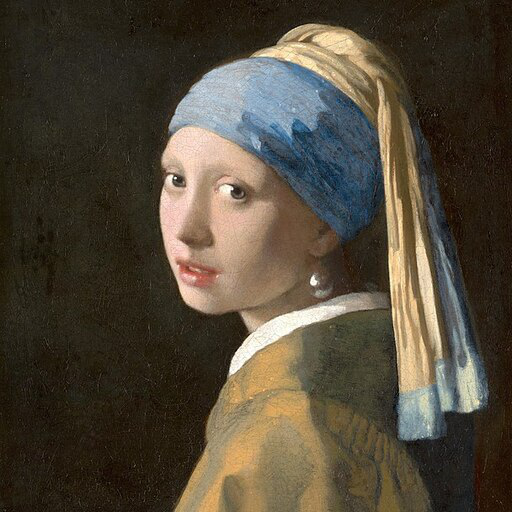

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

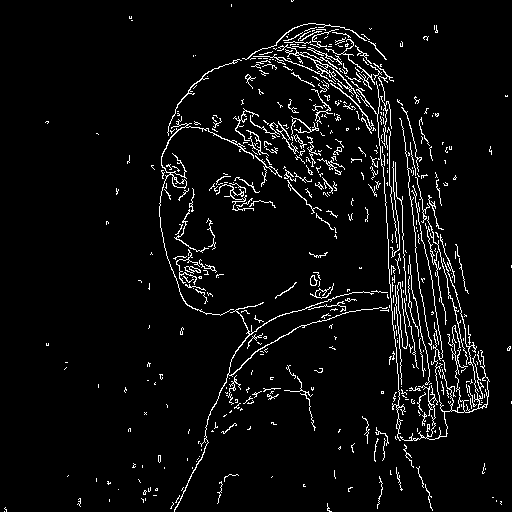

In [4]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

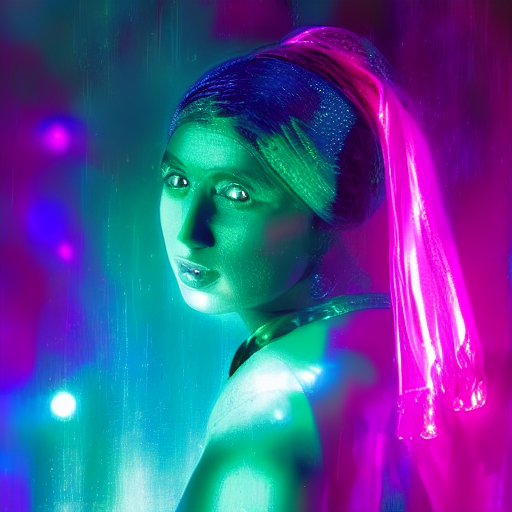

In [7]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['realm, a mystical and serene setting that evokes wonder and awe.']


  0%|          | 0/30 [00:00<?, ?it/s]

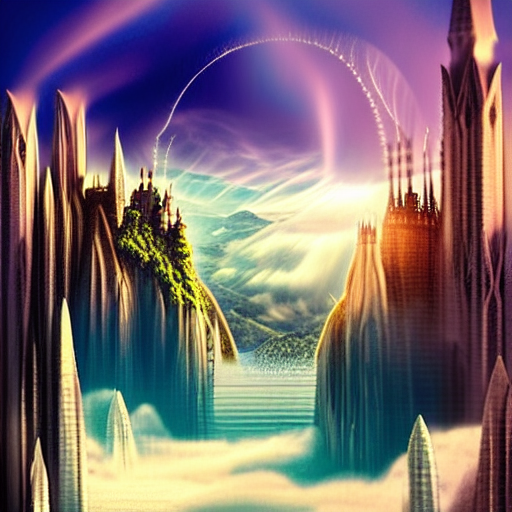

In [8]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
# [[YOUR CODE]]
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")
# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(42)  

prompt = "A grand, majestic floating castle suspended above the clouds, adorned with towering spires and intricate gothic architecture, surrounded by vibrant waterfalls cascading into the sky, shimmering magical energy enveloping the structure, a lush green floating island beneath it, bright golden sunlight breaking through the clouds, ethereal atmosphere, vast sky filled with floating airships and mystical birds, enchanted landscape, fantasy realm, a mystical and serene setting that evokes wonder and awe."
negative_prompt = "blurry, dark, overexposed, low-quality, pixelated, distorted, grainy, dull colors, washed out, low resolution, boring composition, cluttered background, unnatural lighting, overexaggerated shadows, cartoonish, simplistic, uninspired, low detail, flat, uncanny, creepy, noisy, unfinished, low contrast"

# 이미지를 생성합니다. 
canny_image1 = canny_pipe(
    # prompt="disco dancer with colorful lights", 
    # num_inference_steps=20, 
    # generator=generator, 
    # image=canny_image
    prompt=prompt, 
    # negative_prompt=negative_prompt,
    num_inference_steps=30, 
    guidance_scale=8.0, 
    controlnet_conditioning_scale=0.8,  
    generator=generator, 
    image=canny_image 
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image1.save("/aiffel/aiffel/canny_image1.png")  

# 생성된 이미지를 출력합니다. 
canny_image1

## 인체 자세 감지

In [9]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

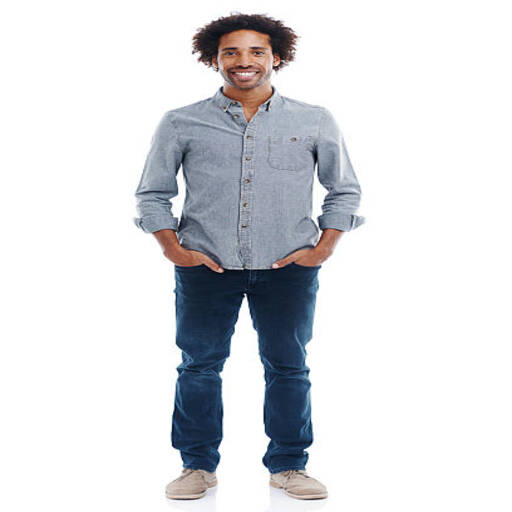

In [10]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


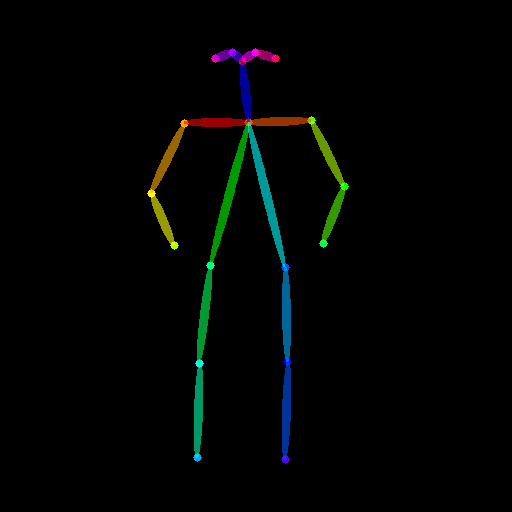

In [11]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

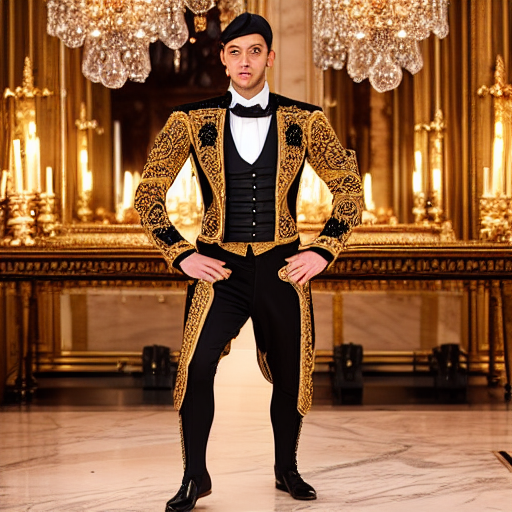

In [13]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
generator = torch.manual_seed(42)  

# 프롬프트 작성
prompt = "An elegant dancer in a grand royal palace, wearing luxurious Victorian-era attire, gracefully moving across the polished marble floor, surrounded by golden chandeliers, soft glowing candlelight, an enchanted evening, highly detailed, cinematic lighting, breathtaking atmosphere"
negative_prompt = "blurry, dark, overexposed, low-quality, pixelated, distorted, grainy, dull colors, washed out, low resolution, boring composition, cluttered background, unnatural lighting, overexaggerated shadows, cartoonish, simplistic, uninspired, low detail, flat, uncanny, creepy, noisy, unfinished, low contrast"
# ControlNet에서 사용할 OpenPose 이미지
images = openpose_image

# 이미지를 생성합니다.
openpose_image1 = openpose_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=30, 
    guidance_scale=8.5,  # 프롬프트 반영 정도
    controlnet_conditioning_scale=1.0,  # OpenPose 이미지 강도 조절
    generator=generator, 
    image=images
).images[0]

# 생성된 이미지를 저장합니다. 
openpose_image1.save("/aiffel/aiffel/openpose_image1.png")  

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/35 [00:00<?, ?it/s]

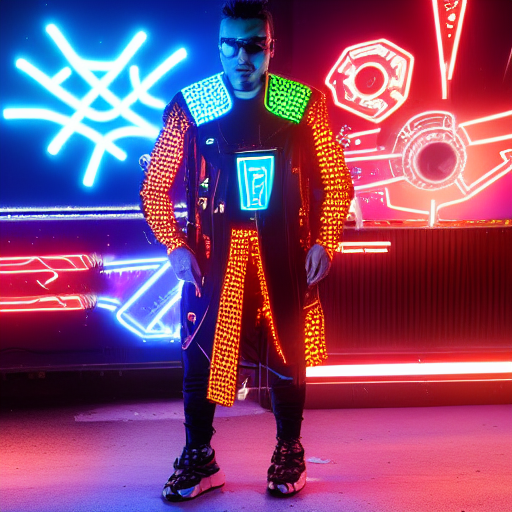

In [15]:
from diffusers import UniPCMultistepScheduler
import torch

# OpenPose 모델의 스케줄러 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(1234)  

# 프롬프트 작성
prompt = "A futuristic cyberpunk character standing confidently in a neon-lit city, wearing a high-tech armored jacket with glowing blue patterns, surrounded by holographic advertisements and flying drones, highly detailed, cinematic lighting, sci-fi atmosphere"

negative_prompt = "blurry, low quality, pixelated, distorted, dull colors, washed out, low resolution, cluttered background, unnatural lighting, overexaggerated shadows, cartoonish, low detail, noisy, unfinished"

# ControlNet에서 사용할 OpenPose 이미지
images = openpose_image

# 이미지를 생성합니다.
openpose_image2 = openpose_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=35,  # 퀄리티 향상을 위해 증가
    guidance_scale=9.0,  # 프롬프트 반영 강도 증가
    controlnet_conditioning_scale=0.9,  # OpenPose 자세 반영 강도 조절
    generator=generator, 
    image=images
).images[0]

# 생성된 이미지를 저장합니다. 
openpose_image2.save("/aiffel/aiffel/openpose_cyberpunk.png")  

# 생성된 이미지를 출력합니다. 
openpose_image2